# Snekmer Demo

In this notebook, we will demonstrate how to apply Snekmer toward the analysis of protein sequences.

## Getting Started

### Workflow

Snekmer proceeds through a defined workflow executed as individual steps on Snakemake. Two operation modes are available: `model` (supervised machine learning) and `cluster` (unsupervised clustering). The user should select the mode that best suits their individual use case.

<img src="https://raw.githubusercontent.com/PNNL-CompBio/Snekmer/main/resources/snekmer_workflow.svg" width="70%" height="70%" >



### Notes on Using Snekmer

Snekmer assumes that the user will primarily process input files using the command line. For more detailed instructions, refer to the [documentation](https://snekmer.readthedocs.io/en/latest/getting_started/cli.html).

The basic process for running Snekmer is as follows:

1. Verify that your file directory structure is correct and that the top-level directory contains a **config.yaml** file.
    - A template configuration file is included in the Snekmer code repository [here](https://github.com/PNNL-CompBio/Snekmer/blob/main/resources/config.yaml).
2. Modify **config.yaml** as needed.
3. Use the command line to navigate to the directory containing both the **config.yaml** file and **_input_** directory.
4. Run `snekmer cluster`, `snekmer model`, or `snekmer search`.

Depending on the selected operation mode, output files will vary.

The process detailed above is handled by the included [tutorial](https://snekmer.readthedocs.io/en/latest/tutorial/index.html). We will use this demo to break down the process followed by the tutorial and understand the output files created in the process.

## Running Snekmer

First, install Snekmer using the instructions in the [user installation guide](https://snekmer.readthedocs.io/en/latest/getting_started/install.html).

To ensure that the tutorial runs correctly, activate the conda environment containing your Snekmer installation and run the notebook from the environment.

Next, run the [Snekmer tutorial](https://snekmer.readthedocs.io/en/latest/tutorial/index.html). This runs all three Snekmer modes on the demo example files and produces all output files. The tutorial uses the included default configuration parameters to guide the analysis, but the user can modify these parameters if a different configuration set is desired. The tutorial command line instructions are copied below:

```bash
    conda activate snekmer
    cd resources/tutorial/demo_example
    ./run_demo.sh
```
    

Finally, we will initialize some parameters and parse filenames for this demo notebook.

In [ ]:
# imports
import glob
import os
import yaml
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# load config file
with open(os.path.join("..", "..", "resources", "config.yaml"), "r") as configfile:
    config = yaml.safe_load(configfile)

print(config)

{'k': 14, 'alphabet': 0, 'input_file_exts': ['fasta', 'fna', 'faa', 'fa'], 'input_file_regex': '.*', 'nested_output': False, 'score': {'scaler': True, 'scaler_kwargs': {'n': 0.25}, 'labels': 'None', 'lname': 'None'}, 'cluster': {'method': 'agglomerative-jaccard', 'params': {'n_clusters': 'None', 'linkage': 'average', 'distance_threshold': 0.92, 'compute_full_tree': True}, 'cluster_plots': False, 'min_rep': None, 'max_rep': None, 'save_matrix': True, 'dist_thresh': 100}, 'model': {'cv': 5, 'random_state': 'None'}, 'model_dir': 'output/example-model/', 'basis_dir': 'output/example-model/', 'score_dir': 'output/example-model/'}


In [8]:
filenames = sorted(
    [
        fa.rstrip(".gz")
        for fa, ext in product(
            glob.glob(os.path.join("demo_example", "input", "*")),
            config["input_file_exts"],
        )
        if fa.rstrip(".gz").endswith(f".{ext}")
    ]
)

families = sorted([os.path.splitext(os.path.basename(f))[0] for f in filenames])

print(families)

['TIGR03149', 'nirS', 'nxrA']


## Snekmer Cluster Mode

Snekmer cluster output files can be found in the **cluster** directory.

In [22]:
# read cluster results
results = pd.read_csv(os.path.join("demo_example", "output", "cluster", "snekmer.csv"))
results

,filename,sequence_id,sequence_length,background,cluster
0,TIGR03149,WP_017422323.1,228,False,0
1,TIGR03149,YP_204935.1,228,False,0
2,TIGR03149,WP_005721361.1,226,False,0
3,TIGR03149,NP_798306.1,228,False,0
4,TIGR03149,NP_439225.1,225,False,0
...,...,...,...,...,...
96,nxrA,WP_080886776.1,1147,False,0
97,nxrA,WP_053381280.1,1145,False,0
98,nxrA,WP_052491869.1,1163,False,0
99,nxrA,WP_015257936.1,1167,False,0


In [23]:
results["cluster"].unique()

array([0])

## Snekmer Model Mode

Snekmer model output files can be found in the **model** directory.

Finally, we train a kmer-based scoring model for the family of interest based on the prevalence of kmers in each family.

In [12]:
# show kmer probability scores for family assignment
example_family = np.random.choice(families)
print("example family:\t", example_family)

# show relevant subset of columns
example_score_output = pd.read_csv(
    os.path.join("demo_example", "output", "scoring", "sequences", f"{example_family}.csv.gz")
)[["filename", "sequence_id", "label", f"{example_family}_score"]]
example_score_output

example family:	 nxrA


,filename,sequence_id,label,nxrA_score
0,nxrA,WP_013249767.1,nxrA,0.779770
1,nxrA,WP_080885705.1,nxrA,0.788867
2,nxrA,WP_013249749.1,nxrA,0.766159
3,nxrA,WP_053381689.1,nxrA,0.977140
4,nxrA,WP_080885591.1,nxrA,0.811505
...,...,...,...,...
96,nirS,WP_011383805.1,nirS,0.050790
97,nirS,WP_049724801.1,nirS,0.070329
98,nirS,WP_041099757.1,nirS,0.060629
99,nirS,WP_015258444.1,nirS,0.077986


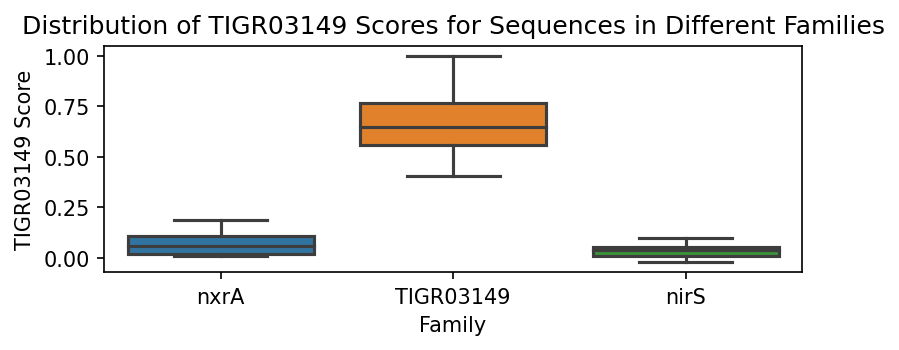

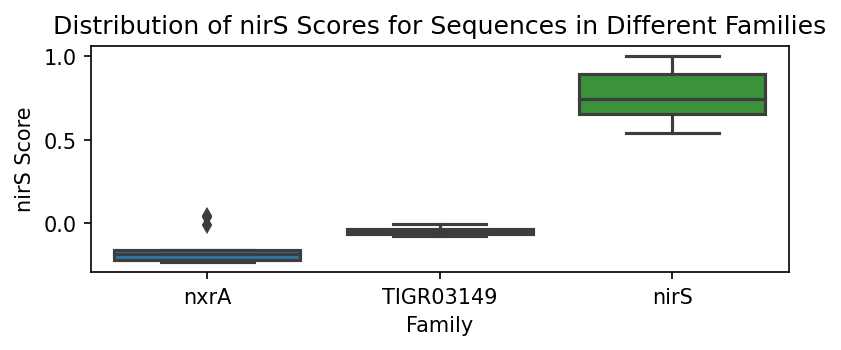

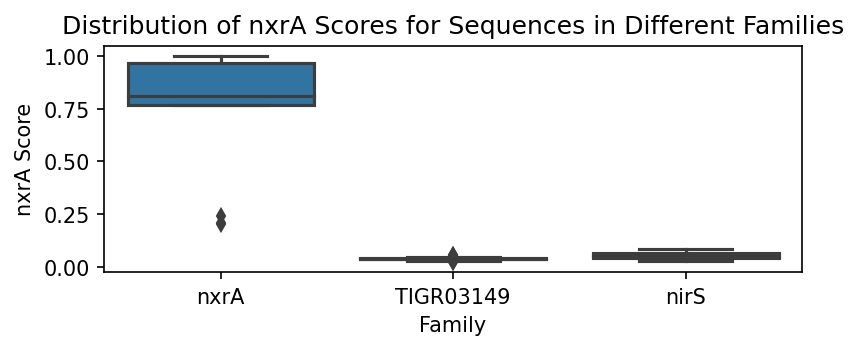

In [14]:
for fam in families:
    example_score_output = pd.read_csv(
        os.path.join("demo_example", "output", "scoring", "sequences", f"{fam}.csv.gz")
    )[["filename", "sequence_id", "label", f"{fam}_score"]]

    plt.figure(figsize=(6, 2), dpi=150)
    ax = sns.boxplot(x="label", y=f"{fam}_score", data=example_score_output)

    ax.set_title(f"Distribution of {fam} Scores for Sequences in Different Families")
    ax.set_xlabel("Family")
    ax.set_ylabel(f"{fam} Score")

We can assess how well the scores perform using the weights determined for each family. Note that it is immediately obvious that the `cNorB` scoring method performs well in identifying cNorB sequences versus the NapB and nirS sequences.

Not all family scoring methods perform similarly well in terms of differentation between sequences belonging to different families. The user can manually inspect the other families, but we note that the NapB family scorer is worse at generating high separation between the in-family and out-of-family sequences. Differing scorer performances can be attributed to a variety of factors, e.g. parameters such as the alphabet and k, existing levels of similarity between sequences in different families, etc.

The probabilities and scores assigned to each feature in the kmer set is also computed and output into a dataframe:

The contents of one of these dataframes is as follows:

In [15]:
print(example_family)
pd.read_csv(os.path.join("demo_example", "output", "scoring", "weights", f"{example_family}.csv.gz"))

nxrA


,kmer,sample,background
0,VSVSVSSSSSVSVS,0.153846,NaN
1,SVSVSSSSSVSVSV,0.461538,NaN
2,VSVSSSSSVSVSVV,0.615385,NaN
3,SVSSSSSVSVSVVS,0.538462,NaN
4,VSSSSSVSVSVVSV,0.615385,NaN
...,...,...,...
3954,SVVSSSVSVSSVVS,0.066719,NaN
3955,VVSSSVSVSSVVSS,0.066719,NaN
3956,VSSSVSVSSVVSSS,0.076923,NaN
3957,SSSVSVSSVVSSSV,0.056515,NaN


Note that this example does not include any sequences specified as background sequences, and thus the `background` column does not contribute additional weights in scoring.

The models are objects stored as pickle files (.PKL) that can be applied elsewhere, e.g. to a new set of unknown sequences.

## Snekmer Search Mode

Say a user trains the four models above, and would then like to score and evaluate sequences with unknown family assignments. The user can use `snekmer search`, which uses the kmer basis set for the desired family to create kmer vectors for unknown sequences, then apply the family scorer to the vectorized unknown sequences, and finally use the model to predict family assignments for the unknown sequences.

These steps are illustrated below:

In [20]:
print("example family:\t", example_family)
pd.read_csv(
    os.path.join("demo_example", "output", "search", example_family, f"{example_family}.csv")
)

example family:	 nxrA


,filename,sequence_id,sequence_length,score,in_family,probability,model
0,nxrA.faa,WP_013249767.1,1147,0.875191,True,0.904374,nxrA.model
1,nxrA.faa,WP_080885705.1,1148,0.898012,True,0.912183,nxrA.model
2,nxrA.faa,WP_013249749.1,1146,0.872509,True,0.903416,nxrA.model
3,nxrA.faa,WP_053381689.1,1145,1.015605,True,0.943950,nxrA.model
4,nxrA.faa,WP_080885591.1,1145,0.899615,True,0.912709,nxrA.model
5,nxrA.faa,WP_053381686.1,1145,1.032662,True,0.947545,nxrA.model
6,nxrA.faa,WP_053378142.1,1145,1.029765,True,0.946950,nxrA.model
7,nxrA.faa,WP_053381277.1,1145,0.998694,True,0.940158,nxrA.model
8,nxrA.faa,WP_080886776.1,1147,0.962465,True,0.931212,nxrA.model
9,nxrA.faa,WP_053381280.1,1145,1.007424,True,0.942145,nxrA.model


In this example application, none of the sequences contained in any of the three unknown files are predicted to belong to the example family, cNorB. The family probability scores themselves (see column: **cNorB_probability**) are very low.